# Challenge: Wine Reviews

# Instructions

Using the CSV file `winereviews.csv` that is bundled with this notebook, perform the following functions. Use this file to write your code.

When you are finished, upload the following items to Collab:
* **This file** with your completed code inserted.
* **The SQLite database** you created, containing the raw imported CSV file and the tables that implement your normalized schema.
* **An image file** of the data model.
* **A flask application file** (e.g. `winereviews.app`), if you decided to complete that task.

# Convert CSV to SQLite

Use the Python libraries `sqlite3` and `pandas` to convert the CSV file on disk to a database table. Name your database file `winereviews.db`.

In [36]:
import pandas as pd
import sqlite3

In [37]:
db = sqlite3.connect('./data/winereviews.db')

In [38]:
raw = pd.read_csv('./data/winereviews.csv', index_col='id')

In [39]:
raw.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


In [40]:
raw.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
id,,,,,,,,,,,,,
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


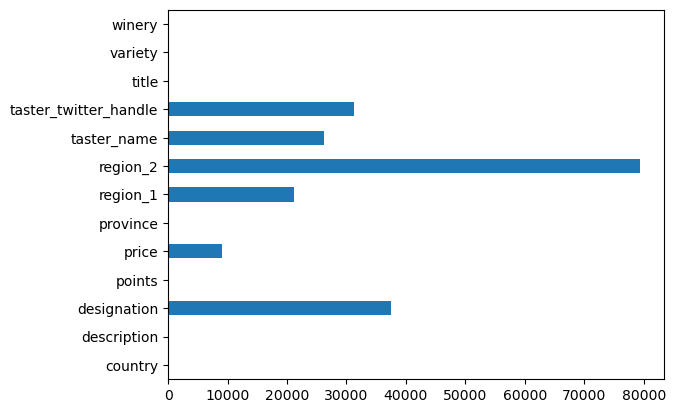

In [41]:
raw.isna().sum().plot.barh();

In [42]:
raw.loc[raw.taster_name.isna(), 'taster_name'] = 'Anonymous'
raw.loc[raw.taster_name == 'Anonymous', 'taster_twitter_handle'] = 'Unkown'

In [43]:
raw.value_counts('taster_name')

taster_name
Anonymous             26244
Roger Voss            25514
Michael Schachner     15134
Kerin O’Keefe         10776
Virginie Boone         9537
Paul Gregutt           9532
Matt Kettmann          6332
Joe Czerwinski         5147
Sean P. Sullivan       4966
Anna Lee C. Iijima     4415
Jim Gordon             4177
Anne Krebiehl MW       3685
Lauren Buzzeo          1835
Susan Kostrzewa        1085
Mike DeSimone           514
Jeff Jenssen            491
Alexander Peartree      415
Carrie Dykes            139
Fiona Adams              27
Christina Pickard         6
dtype: int64

In [44]:
raw.drop_duplicates().shape, raw.shape

((119988, 13), (129971, 13))

In [45]:
raw = raw.drop_duplicates()

In [46]:
raw.to_sql('review_raw', db, if_exists='replace', index=True) # Don't really have to do this

119988

# Identify the entities

Using our intuition, we view the table and identify the implied subjects, or entities, in the data. 

* REVIEW
* TASTER
* WINE
* PLACE
* COUNTRY

# Create tables for each of the entities

Using the techniques described in class and in the Jupyter notebooks, create the tables corresponding to your normalized schema.


## Create `taster`

Note how we handle `NULL`s here. We don't replace them right away, since we want to make sure we don't include in our table a row with two empty values. That is, even though there are records in `review_raw` that do not have `taster_name` values, this does not mean that we want to include in `taster` a row with no values.

In [47]:
taster = raw[['taster_name', 'taster_twitter_handle']].value_counts().to_frame('n_reviews')

In [48]:
taster = taster.reset_index().set_index('taster_name')

In [49]:
taster

,taster_twitter_handle,n_reviews
taster_name,,
Anonymous,Unkown,24917
Roger Voss,@vossroger,23560
Michael Schachner,@wineschach,14046
Kerin O’Keefe,@kerinokeefe,9697
Paul Gregutt,@paulgwine,8868
Virginie Boone,@vboone,8708
Matt Kettmann,@mattkettmann,5730
Joe Czerwinski,@JoeCz,4766
Sean P. Sullivan,@wawinereport,4461


In [50]:
taster.to_sql('taster', db, if_exists='replace', index=True)

17

## Create `wine`

Note that in this phase of the operation, we need to pull data from the wine entity as well as the keys from dependent tables.

In [51]:
wine_cols = 'title winery variety designation country province region_1 region_2'.split()
wine = raw[wine_cols].value_counts().to_frame('n_reviews')

In [52]:
wine = wine.reset_index().set_index(['title','winery'])

Note that we have some duplicates in the index. This is not good. In a real project, we'd remove these.

In [53]:
wine.loc[wine.index.duplicated()]

,,variety,designation,country,province,region_1,region_2,n_reviews
title,winery,,,,,,,
Cooper-Garrod 2011 Test Pilot Red (Santa Cruz Mountains),Cooper-Garrod,Bordeaux-style Red Blend,Test Pilot,US,California,Santa Cruz Mountains,Central Coast,1
Ascension Cellars 2015 Silver White (Paso Robles),Ascension Cellars,White Blend,Silver,US,California,Paso Robles,Central Coast,1
Force Majeure 2014 Parabellum Red (Red Mountain),Force Majeure,Bordeaux-style Red Blend,Parabellum,US,Washington,Red Mountain,Columbia Valley,1


In [54]:
wine.loc['Force Majeure 2014 Parabellum Red (Red Mountain)']

,variety,designation,country,province,region_1,region_2,n_reviews
winery,,,,,,,
Force Majeure,Rhône-style Red Blend,Parabellum,US,Washington,Red Mountain,Columbia Valley,1
Force Majeure,Bordeaux-style Red Blend,Parabellum,US,Washington,Red Mountain,Columbia Valley,1


In [55]:
wine.to_sql('wine', con=db, if_exists='replace', index=True)

31538

## Create `place`

In [56]:
place_cols = 'country province region_1 region_2'.split()
place = raw[place_cols].value_counts().to_frame('n_reviews')

In [57]:
place

n_reviews
country province   region_1                           region_2                   
US      California Napa Valley                        Napa                   4174
        Washington Columbia Valley (WA)               Columbia Valley        3795
        California Russian River Valley               Sonoma                 2862
                   California                         California Other       2468
                   Paso Robles                        Central Coast          2155
...                                                                           ...
                   Sonoma-Napa-Monterey               California Other          1
                   Sonoma-Napa-Mendocino              North Coast               1
                   Sonoma-Napa-Lake                   North Coast               1
                   Sonoma County-Santa Barbara County California Other          1
                   Lake-Sonoma-Napa                   North Coast               1

[203 rows x 1 columns]

In [58]:
place.to_sql('place', db, if_exists='replace', index=True)

203

## Create `country`*

This is not part of a our model. But I show this to prove a point -- that in the process of implementing a model, you might discover another 

In [59]:
country = raw.country.value_counts().to_frame('n_reviews')
country.index.name = 'country_id'

In [60]:
country

,n_reviews
country_id,
US,50457
France,20353
Italy,17940
Spain,6116
Portugal,5256
Chile,4184
Argentina,3544
Austria,3034
Australia,2197


In [61]:
country.to_sql('country', db, if_exists='replace', index=True)

43

## Create `review`

In [62]:
review_idx_cols = ['title','winery','taster_name']
review_cols = ['description','taster_name','points','price','title','winery']

In [63]:
review = raw[review_cols].copy().set_index(review_idx_cols)

In [64]:
review

,,,description,points,price
title,winery,taster_name,,,
Nicosia 2013 Vulkà Bianco (Etna),Nicosia,Kerin O’Keefe,"Aromas include tropical fruit, broom, brimston...",87,NaN
Quinta dos Avidagos 2011 Avidagos Red (Douro),Quinta dos Avidagos,Roger Voss,"This is ripe and fruity, a wine that is smooth...",87,15.0
Rainstorm 2013 Pinot Gris (Willamette Valley),Rainstorm,Paul Gregutt,"Tart and snappy, the flavors of lime flesh and...",87,14.0
St. Julian 2013 Reserve Late Harvest Riesling (Lake Michigan Shore),St. Julian,Alexander Peartree,"Pineapple rind, lemon pith and orange blossom ...",87,13.0
Sweet Cheeks 2012 Vintner's Reserve Wild Child Block Pinot Noir (Willamette Valley),Sweet Cheeks,Paul Gregutt,"Much like the regular bottling from 2012, this...",87,65.0
...,...,...,...,...,...
Dr. H. Thanisch (Erben Müller-Burggraef) 2013 Brauneberger Juffer-Sonnenuhr Spätlese Riesling (Mosel),Dr. H. Thanisch (Erben Müller-Burggraef),Anna Lee C. Iijima,Notes of honeysuckle and cantaloupe sweeten th...,90,28.0
Citation 2004 Pinot Noir (Oregon),Citation,Paul Gregutt,Citation is given as much as a decade of bottl...,90,75.0
Domaine Gresser 2013 Kritt Gewurztraminer (Alsace),Domaine Gresser,Roger Voss,Well-drained gravel soil gives this wine its c...,90,30.0


In [65]:
review.to_sql('review', db, if_exists='replace', index=True)

119988

**Question:** Why is `price` a field in `review` and not `wine`?